In [71]:
#imports
import numpy as np
from numpy.random import choice as sample
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [72]:
path = '/Users/kirtan/Downloads/1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [73]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [74]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

# Feature Engineering

In [75]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [76]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [77]:
print(X[0][0])

[False False False ... False False False]


# Building the Recurrent Neural network

In [78]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Training the Next Word Prediction Model

In [79]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
811/811 [==============================] - 161s 197ms/step - loss: 5.9989 - accuracy: 0.1077 - val_loss: 7.0411 - val_accuracy: 0.0981
Epoch 2/2
811/811 [==============================] - 161s 199ms/step - loss: 5.7769 - accuracy: 0.1491 - val_loss: 7.8815 - val_accuracy: 0.1056


In [80]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

# Evaluating the Next Word Prediction Model

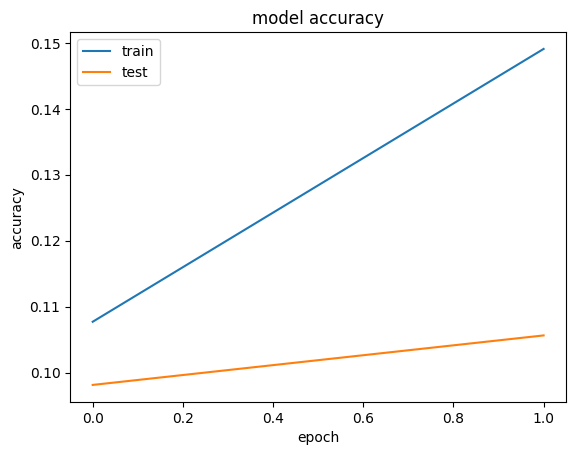

In [81]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


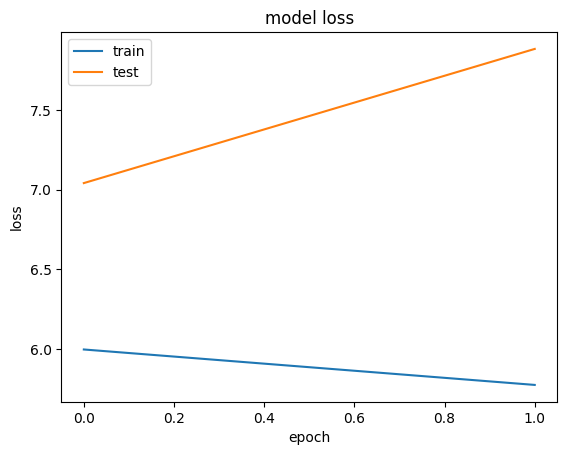

In [82]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Testing Next Word Prediction Model

In [83]:
SEQUENCE_LENGTH = 500
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [84]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [85]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

# Create a function to return samples

In [86]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages",
    "That which does not kill us makes us stronger",
    "I'm not upset that you lied to me I'm upset that from now on I can't believe you",
    "And those who were seen dancing were thought to be insane by those who could not hear the music",
    "It is hard enough to remember my opinions, without also remembering my reasons for them"
]

In [87]:
unique_words = sorted(list(set(words)))
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
indices_char = dict((i, c) for i, c in enumerate(unique_words))

In [88]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(unique_words))))
model.add(Dropout(0.2))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [89]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()[-SEQUENCE_LENGTH:]):
        if word in unique_word_index:
            x[0, t, unique_word_index[word]] = 1
    return x


In [90]:
def predict_completion(text):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, top_n=1)[0]
    next_char = indices_char[next_index]
    text = text[1:] + next_char
    return text

In [94]:
def predict_completions(text, n=5):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = [idx for idx in sample(preds, n) if idx in indices_char]
    return [text + ' ' + predict_completion(text + ' ' + indices_char[idx]) for idx in next_indices]


In [95]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 10))
    print()

it is not a lack of love, but a lack of 
[]

that which does not kill us makes us str
[]

i'm not upset that you lied to me i'm up
[]

and those who were seen dancing were tho
[]

it is hard enough to remember my opinion
[]

